# Training Word2Vec model








In [ ]:
!pip install underthesea 

     |████████████████████████████████| 7.6 MB 27.1 MB/s 
     |████████████████████████████████| 235 kB 69.9 MB/s 
     |████████████████████████████████| 581 kB 65.7 MB/s 
     |████████████████████████████████| 965 kB 65.3 MB/s 


In [ ]:
# common
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# languages
from underthesea import word_tokenize

#Modeling packages
from sklearn.model_selection import train_test_split

# Word2vec
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import data
df_new=pd.read_excel(' ')
df_new['comment_1'].head(20)

0                                 vải thô không_mềm bạc
1                         vải dày tốt áo y hình rất_đẹp
2                      mặc đi không_được mặc không_xong
3                                      áo chật ngắn gầy
4                                                  chặt
5                          may vớt vội áo trắng hỏng áo
6                                                tất cổ
7                                        rẻ bảo vải đẹp
8                               chất vải không_được đẹp
9                                         đường may xấu
10                              chữ black rất_to tệ ảnh
11                                đặt size ship sai mày
12                                          áo vải cứng
13                 hình tưởng áo màu trắng_tinh màu ngà
14           giao hàng nhanh đồ rất_đẹp đặt màu cam màu
15    bọn lừa mua quần tặng vợ lai gửi tao quần khôn...
16                                         vải rất_mõng
17                                          zip 

In [ ]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 9 # max distance bt the current and predicted
W2V_EPOCH = 35 
W2V_MIN_COUNT = 6 # Ignore word frequence < n
SEED = 123 # random


In [ ]:
# model dùng Bag of word
w2v_model = Word2Vec(
                        seed=SEED, 
                        size=W2V_SIZE,
                        window=W2V_WINDOW,
                        min_count=W2V_MIN_COUNT
                        )

In [ ]:
documents = [_text.split() for _text in df_new.comment_1.astype(str)]


In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
w2v_model.build_vocab(tqdm(documents))

100%|██████████| 15755/15755 [00:00<00:00, 508376.04it/s]


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 7.26 s, sys: 69.8 ms, total: 7.33 s
Wall time: 4.28 s


(2098020, 3694985)

In [ ]:
w2v_model.most_similar(positive='đẹp',topn=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('xinh', 0.6657857894897461),
 ('rất_đẹp', 0.5948681235313416),
 ('rất_ok', 0.5934178829193115),
 ('sét', 0.5753581523895264),
 ('đẹp_shop', 0.5701394081115723),
 ('xịn', 0.5566124320030212),
 ('rất_ưng', 0.5537118315696716),
 ('giống_y', 0.5470337867736816),
 ('rất_ưng_ý', 0.5413988828659058),
 ('rất_xinh', 0.5393843054771423),
 ('rất_tôn', 0.5356530547142029),
 ('cực', 0.532812237739563),
 ('rất_hài_lòng', 0.53164142370224),
 ('siêu', 0.5284671187400818),
 ('rất_thích', 0.5227182507514954),
 ('y_hình', 0.5220340490341187),
 ('rất_chuẩn', 0.5179232954978943),
 ('rất_là', 0.5052216053009033),
 ('y', 0.5044524073600769),
 ('dày_dặn', 0.501775324344635),
 ('cute', 0.4949120879173279),
 ('phom', 0.4880654215812683),
 ('cực_kì', 0.4824509620666504),
 ('co_dãn', 0.4782862365245819),
 ('mát', 0.4766955077648163),
 ('thân_thiện', 0.4700275659561157),
 ('cám_ơn', 0.4579432010650635),
 ('nhg', 0.4528568983078003),
 ('khen', 0.4526202082633972),
 ('gọn', 0.4524696469306946),
 ('rất_rất', 0.4481

In [ ]:
w2v_model.similarity("đẹp","xinh")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.66578585

In [ ]:
w2v_model.save("w2v.model")

# Sentence2vec




In [ ]:
import re
import numpy as np
from numpy import dot
from numpy.linalg import norm
from gensim.models import Word2Vec
from underthesea import word_tokenize


In [ ]:
# Hàm Sentence2vec dựa trên word2vec 
class Sentence2Vec:
    def __init__(self, model_file):
        self.load(model_file)

    def load(self, model_file):
        self.model = Word2Vec.load(model_file)

    def get_vector(self, sentence):
        vectors = [self.model.wv[w] for w in word_tokenize(sentence)
                   if w in self.model.wv]

        v = np.zeros(self.model.vector_size)

        if (len(vectors) > 0):
            v = (np.array([sum(x) for x in zip(*vectors)])) / v.size
        return v

    def similarity(self, x, y):
        xv = self.get_vector(x)
        yv = self.get_vector(y)

        score = 0

        if xv.size > 0 and yv.size > 0:
            score = dot(xv, yv) / (norm(xv) * norm(yv))

        return score


In [ ]:
model = Sentence2Vec('w2v.model')

In [ ]:
matrix = np.zeros((len(documents),W2V_SIZE))
for i in range(len(documents)):
        matrix[i] = model.get_vector(str(documents[i]))
print(matrix.shape)

(15755, 300)


# PCA to reduce dimention (40D)




In [ ]:
from sklearn.decomposition import PCA

# fit a 40d PCA model to the vectors

pca = PCA(n_components=40)
PCA_result = pca.fit_transform(matrix)
print(PCA_result.shape)

(15755, 40)


# K-mean clustering

In [ ]:
from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=20,avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(PCA_result, assign_clusters=True)
print (assigned_clusters)

[0, 1, 2, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 2, 2, 2, 1, 0, 1, 0, 2, 0, 1, 2, 2, 0, 1, 0, 1, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 1, 2, 0, 0, 0, 1, 0, 2, 2, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 1, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 2, 1, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 

In [ ]:
assigned_clusters = np.array(assigned_clusters)

# **Result**

In [ ]:
pca = PCA(n_components=2)
PCA_new = pca.fit_transform(matrix)

In [ ]:
d = {'document' : df_new["comment_1"], 'label':assigned_clusters, 'x': PCA_new[:,0], 'y': PCA_new[:,1]}
df = pd.DataFrame(data=d)

In [ ]:
file_data='/content/drive/MyDrive/Unsupervised_3_classes.xlsx'
df.to_excel(file_data)

In [ ]:
#filter rows of original data
filtered_label0 = df[assigned_clusters == 0]
filtered_label1 = df[assigned_clusters == 1]
filtered_label2 = df[assigned_clusters == 2]
#filtered_label3 = df[assigned_clusters == 3]

In [ ]:
filtered_label0.head(60)

,document,label,x,y
0,vải thô không_mềm bạc,0,-0.034704,-0.021363
4,chặt,0,-0.025625,0.005368
5,may vớt vội áo trắng hỏng áo,0,-0.023981,-0.019293
6,tất cổ,0,-0.028796,-0.003526
8,chất vải không_được đẹp,0,-0.016785,-0.014976
9,đường may xấu,0,-0.020163,-0.018329
10,chữ black rất_to tệ ảnh,0,-0.022883,0.005011
12,áo vải cứng,0,-0.027003,-0.016689
13,hình tưởng áo màu trắng_tinh màu ngà,0,-0.025347,-0.033479
16,vải rất_mõng,0,-0.020262,-0.008123


In [ ]:
filtered_label1.head(50)

,document,label,x,y
1,vải dày tốt áo y hình rất_đẹp,1,0.010688,-0.016046
7,rẻ bảo vải đẹp,1,0.001275,-0.003119
14,giao hàng nhanh đồ rất_đẹp đặt màu cam màu,1,0.059669,-0.037183
15,bọn lừa mua quần tặng vợ lai gửi tao quần khôn...,1,0.065557,0.021792
21,quần áo gói túi zip rất_chất_lượng,1,0.001841,-0.010456
22,cửa hàng khâu_vá,1,0.021607,0.000859
23,vải rất_mỏng rất_cũ giao hàng rất_nhanh,1,0.040380,-0.027966
30,hàng tệ giày sản_phẩm đóng_gói hộp tệ tả_tơi,1,0.050688,-0.018468
32,giao ổn đc rất_tệ,1,0.003928,-0.005443
36,ao đc đep,1,0.004408,0.001801


In [ ]:
filtered_label2.head(50)

,document,label,x,y
2,mặc đi không_được mặc không_xong,2,-0.017710,0.022334
3,áo chật ngắn gầy,2,-0.024843,0.032476
11,đặt size ship sai mày,2,0.026881,0.058570
26,quần size bé,2,-0.005700,0.044134
27,kí tệ dày,2,-0.015456,0.019534
28,áo ngắn rất_mô mặc đc,2,-0.020893,0.023387
29,đừơg may rất_ngay cổ áo mặc dcbực tiền mặc,2,-0.012229,0.014033
34,mặc đau nách,2,-0.026428,0.017053
37,sai_lầm mua quần_áo rẻ tệ,2,0.002380,0.012878
38,size mốc,2,-0.012432,0.016265


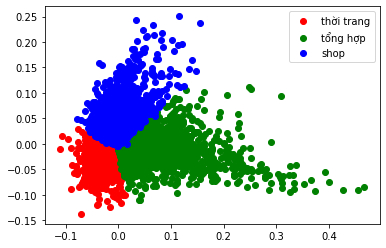

In [ ]:
#Plotting the results
fig, ax = plt.subplots()
scatter0= plt.scatter(filtered_label0['x'] , filtered_label0['y'] , color = 'red')
scatter1 = plt.scatter(filtered_label1['x'] , filtered_label1['y'] , color = 'green')
scatter2 = plt.scatter(filtered_label2['x'] , filtered_label2['y'] , color = 'blue')
ax.legend([scatter0, scatter1, scatter2], [' ', ' ', ' '])

plt.show()
